# EhV: Leiden clustering explanation using SHAP

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [54]:
import anndata
import scanpy
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, train_test_split

from ehv.core import plot_gate_zarr_channels

In [4]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [5]:
adata = anndata.read_h5ad(data_dir / "analysis.h5ad")

Transforming to str index.


## Cross-validate model

In [6]:
def cv_wrapper(X, y, model, seed=42):
    numpy.random.seed(seed)
    
    scoring = ('balanced_accuracy', 'f1_macro', 'f1_micro', 'precision_macro', 'precision_micro', 'recall_macro', 'recall_micro')
    cv_results = cross_validate(
        estimator=model,
        X=X.values, y=y, cv=5,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
        n_jobs=5,
        verbose=0
    )
    cv_df = pandas.DataFrame(
        data = {
            **{"phase": ["train"] * 5 + ["test"] * 5},
            **{k: numpy.concatenate([cv_results[f"train_{k}"], cv_results[f"test_{k}"]]) for k in scoring}
        }
    ).melt(id_vars=["phase"])
    seaborn.stripplot(data=cv_df, y="variable", x="value", hue="phase", jitter=0)
    return cv_df

In [7]:
X = adata[:, adata.var.selected_corr].to_df()
y = adata[:, adata.var.selected_corr].obs["leiden"]

<AxesSubplot:xlabel='leiden', ylabel='count'>

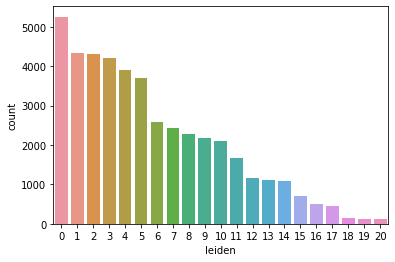

In [8]:
seaborn.countplot(x=y)

In [9]:
rf = RandomForestClassifier(n_estimators = 10)

CPU times: user 264 ms, sys: 112 ms, total: 376 ms
Wall time: 1min 12s


,phase,variable,value
0,train,balanced_accuracy,0.996091
1,train,balanced_accuracy,0.991231
2,train,balanced_accuracy,0.993151
3,train,balanced_accuracy,0.994952
4,train,balanced_accuracy,0.995413
...,...,...,...
65,test,recall_micro,0.838346
66,test,recall_micro,0.886223
67,test,recall_micro,0.882393
68,test,recall_micro,0.888926


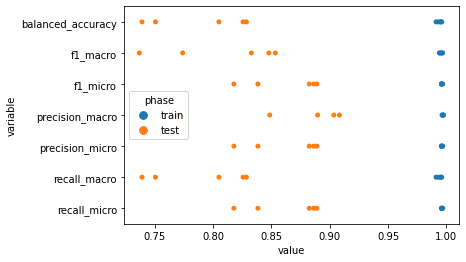

In [20]:
%%time
cv_wrapper(X, y, rf)

# Explain

In [10]:
%%time
rf.fit(X, y)

CPU times: user 12.7 s, sys: 0 ns, total: 12.7 s
Wall time: 12.8 s


RandomForestClassifier(n_estimators=10)

In [11]:
# stratified subsample
idx, _ = train_test_split(numpy.arange(len(X)), test_size=.5, stratify=y)

In [12]:
numpy.random.seed(0)
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X.iloc[idx])

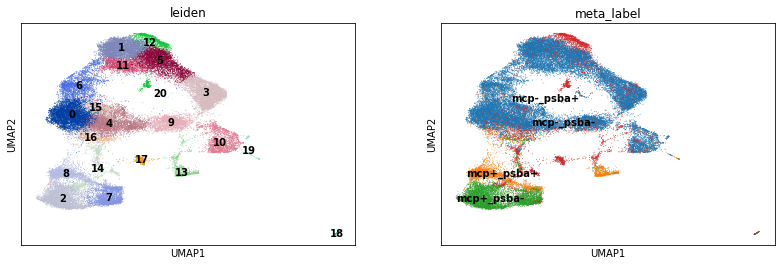

In [24]:
scanpy.pl.umap(adata, color=["leiden", "meta_label"], legend_loc="on data")

<AxesSubplot:xlabel='leiden', ylabel='count'>

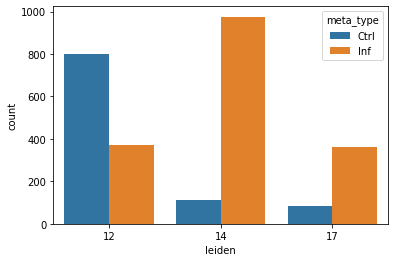

In [49]:
tmp_df = scanpy.get.obs_df(adata[adata.obs["clust_type"] == "mcp-_psba-"], keys=["leiden", "meta_type"])
seaborn.countplot(data=tmp_df, x="leiden", hue="meta_type")

<AxesSubplot:xlabel='meta_label', ylabel='count'>

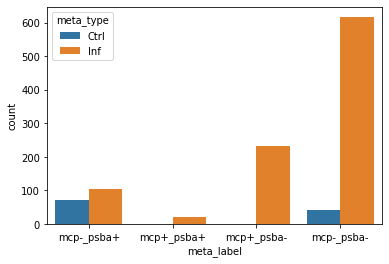

In [50]:
tmp_df = scanpy.get.obs_df(adata[adata.obs["leiden"] == "14"], keys=["meta_label", "meta_type"])
seaborn.countplot(data=tmp_df, x="meta_label", hue="meta_type")

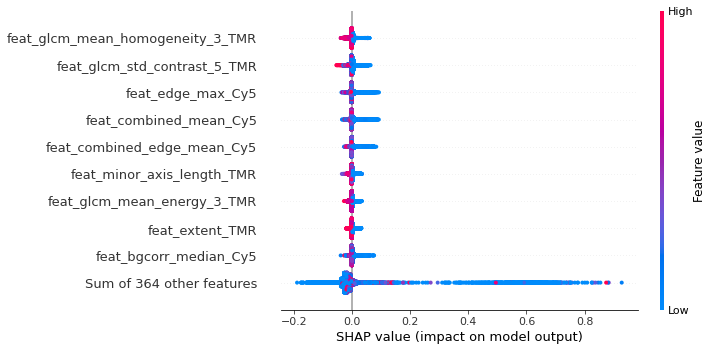

In [43]:
shap.plots.beeswarm(shap_values[..., rf.classes_.tolist().index('12')])

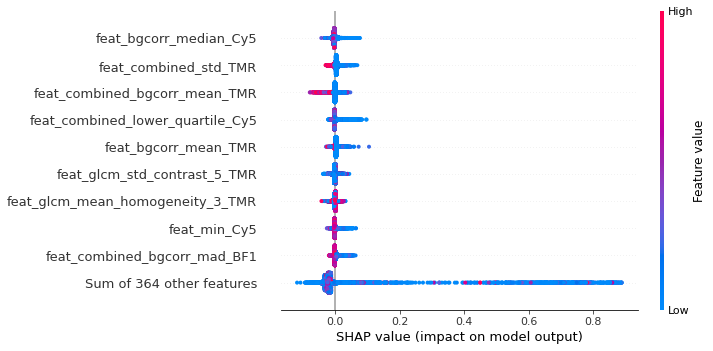

In [29]:
shap.plots.beeswarm(shap_values[..., rf.classes_.tolist().index('14')])

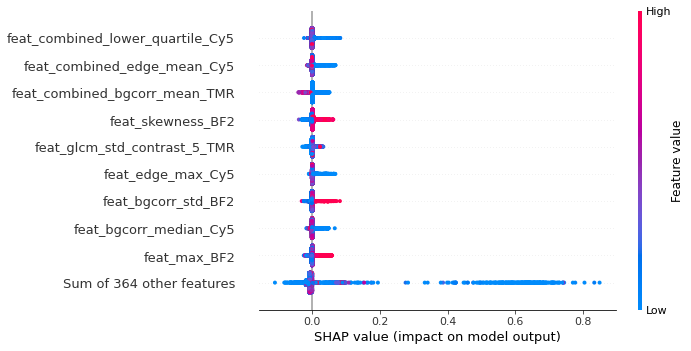

In [51]:
shap.plots.beeswarm(shap_values[..., rf.classes_.tolist().index('17')], max_display=10)

In [76]:
adata.layers["scaled"] = scanpy.pp.scale(adata, copy=True).X

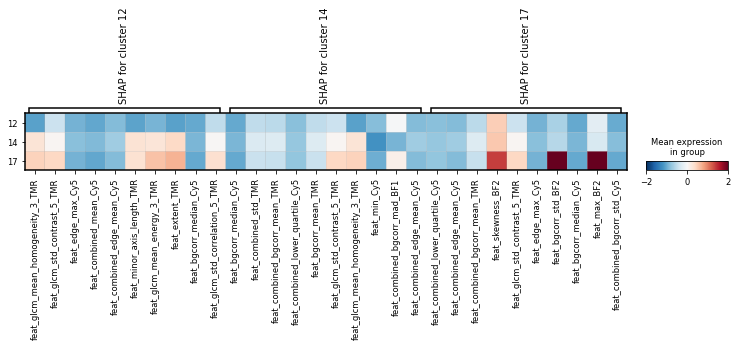

In [92]:
sort_idx = {
    f"SHAP for cluster {c}": X.columns[numpy.argsort(shap_values[..., rf.classes_.tolist().index(c)].abs.mean(0).values)[::-1][:10].tolist()]
    for c in ['12', '14', '17']
}
scanpy.pl.matrixplot(
    adata[adata.obs.leiden.isin(['12', '14', '17'])], 
    var_names=sort_idx, groupby="leiden",
    layer="scaled",
    vmin=-2, vmax=2, cmap="RdBu_r",
    swap_axes=False
)

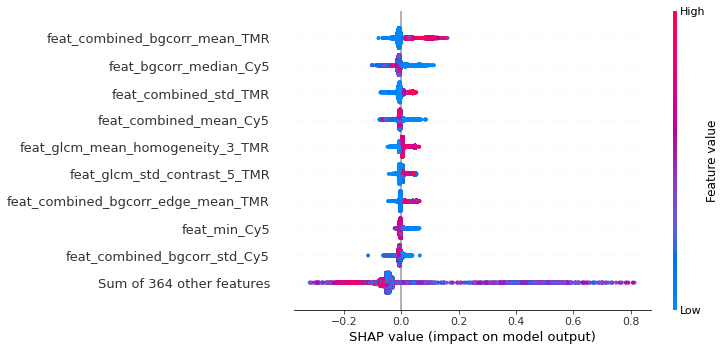

In [31]:
shap.plots.beeswarm(shap_values[..., rf.classes_.tolist().index('2')])

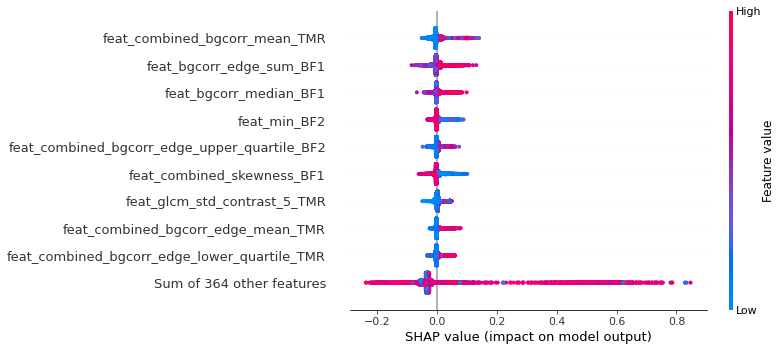

In [32]:
shap.plots.beeswarm(shap_values[..., rf.classes_.tolist().index('7')])

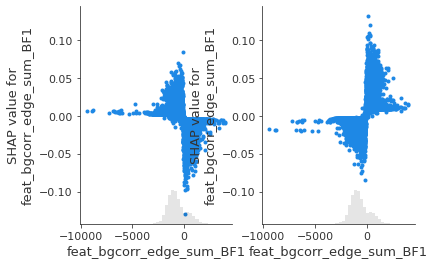

In [36]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
shap.plots.scatter(shap_values[:, "feat_bgcorr_edge_sum_BF1", rf.classes_.tolist().index('7')], ax=axes[1], show=False)
shap.plots.scatter(shap_values[:, "feat_bgcorr_edge_sum_BF1", rf.classes_.tolist().index('2')], ax=axes[0], show=False)

All-NaN slice encountered
All-NaN slice encountered


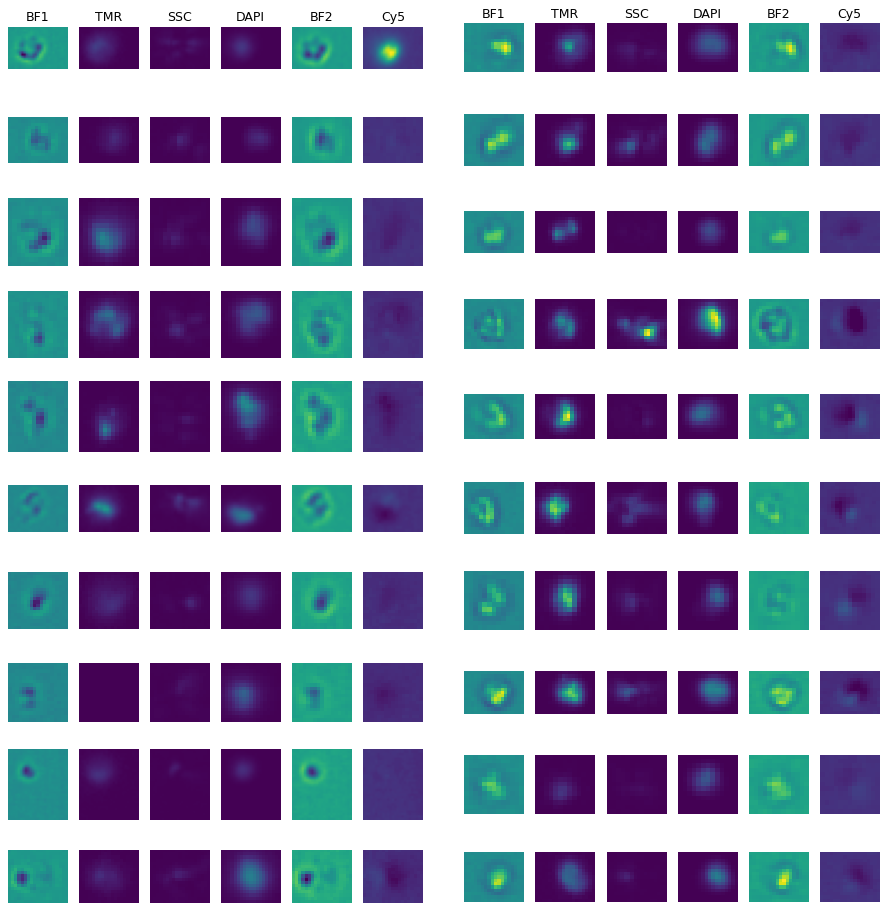

In [61]:
tmp_df = scanpy.get.obs_df(adata, keys=["feat_bgcorr_edge_sum_BF1"] + adata.obs.columns.tolist())

plot_gate_zarr_channels(
    selectors=[
        tmp_df.leiden.isin(['2', '7']) & (tmp_df["feat_bgcorr_edge_sum_BF1"] > 200),
        tmp_df.leiden.isin(['2', '7']) & (tmp_df["feat_bgcorr_edge_sum_BF1"] < -200)
    ],
    df=tmp_df,
    maxn=10,
    channel_ind=[0,1,3,4,5,6], channel_names=["BF1", "TMR", "SSC", "DAPI", "BF2", "Cy5"]
)

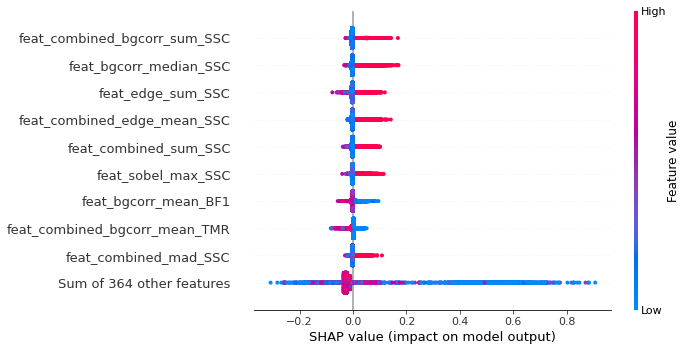

In [37]:
shap.plots.beeswarm(shap_values[..., rf.classes_.tolist().index('10')])

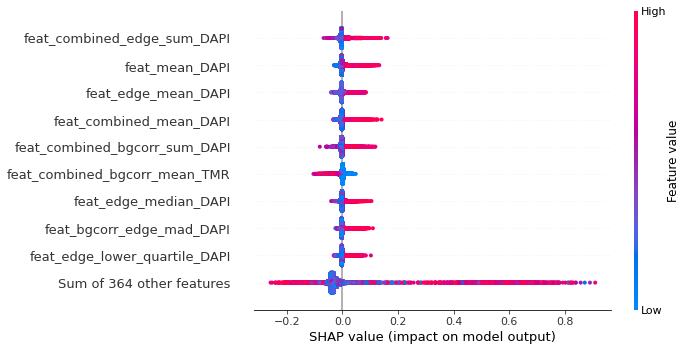

In [52]:
shap.plots.beeswarm(shap_values[..., rf.classes_.tolist().index('6')])

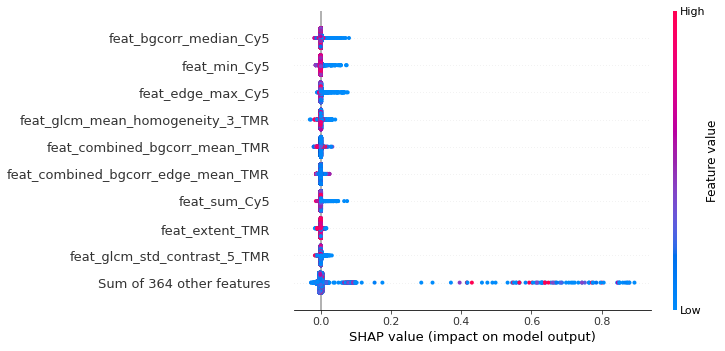

In [62]:
shap.plots.beeswarm(shap_values[..., rf.classes_.tolist().index('18')])